In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from math import ceil

In [2]:
df = pd.read_csv('D:/Myworks/Tesla Dataset.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509 entries, 0 to 3508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3509 non-null   object 
 1   Open       3509 non-null   float64
 2   High       3509 non-null   float64
 3   Low        3509 non-null   float64
 4   Close      3509 non-null   float64
 5   Adj Close  3509 non-null   float64
 6   Volume     3509 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 192.0+ KB


In [4]:
df.describe

<bound method NDFrame.describe of             Date        Open        High         Low       Close   Adj Close  \
0     2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
1     2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2     2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
3     2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
4     2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...          ...         ...         ...         ...         ...         ...   
3504  2024-05-31  178.500000  180.320007  173.820007  178.080002  178.080002   
3505  2024-06-03  178.130005  182.639999  174.490005  176.289993  176.289993   
3506  2024-06-04  174.779999  177.759995  174.000000  174.770004  174.770004   
3507  2024-06-05  175.350006  176.149994  172.130005  175.000000  175.000000   
3508  2024-06-06  174.419998  176.919998  172.729996  175.440002  175.440002   

     

In [6]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df["Date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3509 entries, 0 to 3508
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
3509 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 27.5 KB


Text(0.5, 1.0, 'Tesla Closing Prices (in USD)')

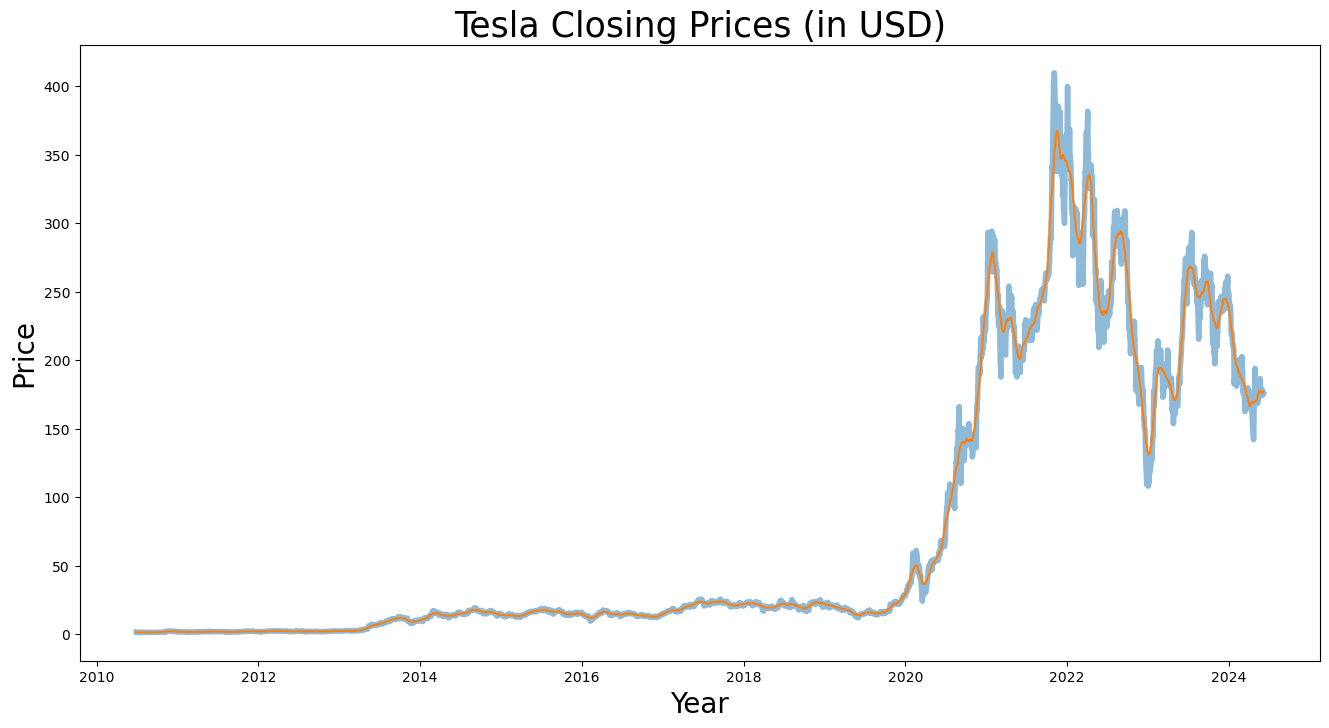

In [7]:
# Plot of Tesla Closing Price
plt.figure(figsize=(16,8))
sns.lineplot(x=df['Date'],y=df['Close'], alpha=0.5,linewidth=4)
sns.lineplot(x=df['Date'],y=df['Close'].rolling(window=30, center=True, min_periods=15).mean())
plt.xlabel('Year',size=20)
plt.ylabel('Price',size=20)
plt.title('Tesla Closing Prices (in USD)',size=25)

Text(0.5, 1.0, 'Distribution of Tesla Closing Prices using Histogram')

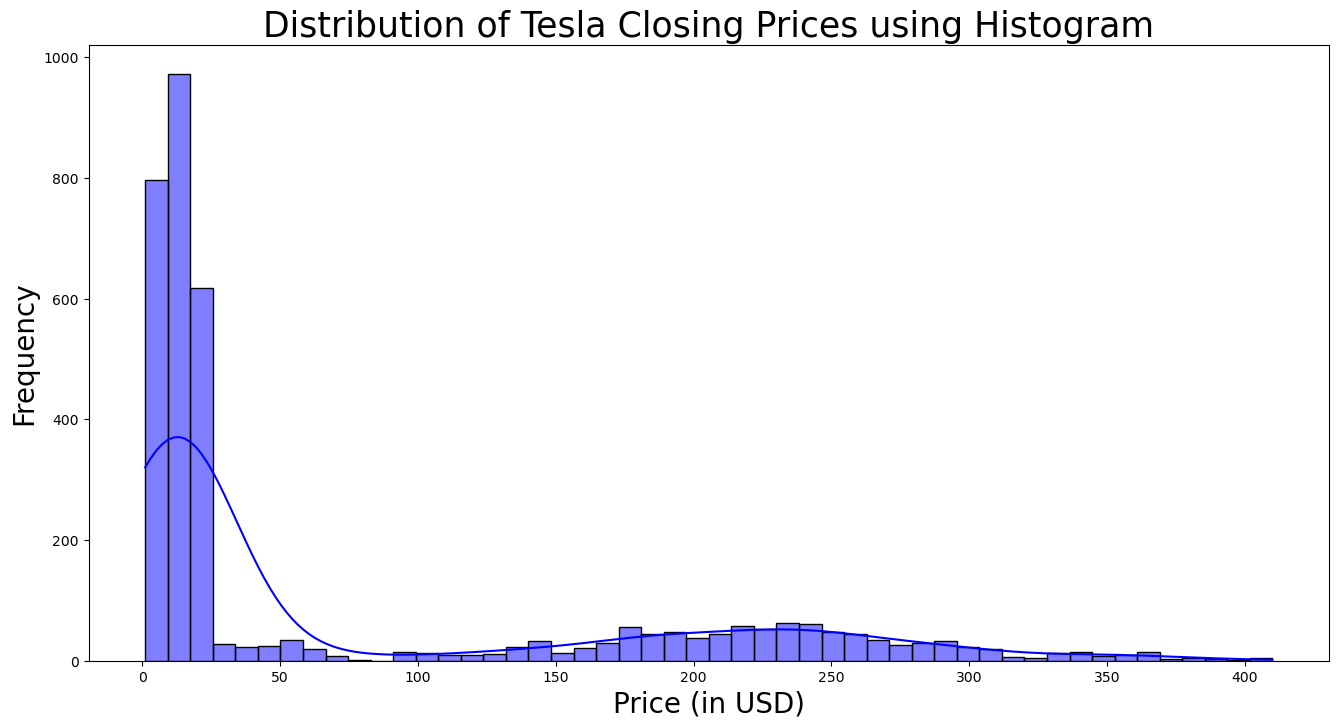

In [8]:
# Histogram of closing price frequency

plt.figure(figsize=(16,8))
sns.histplot(df['Close'], kde=True, bins=50, color='b')
plt.xlabel('Price (in USD)',size=20)
plt.ylabel('Frequency',size=20)
plt.title('Distribution of Tesla Closing Prices using Histogram',size=25)

# Normalizing the dataset
Normalizing the data using MinMaxScaler in range [0,1]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
x = df['Close'].values.reshape(-1,1)
df['Close'] = scaler.fit_transform(x)
x.shape

(3509, 1)

## Train-test split

In [10]:
# instances = df.shape[0]

train_set= df['Close'].iloc[:ceil(int(len(df))*0.75)]
validation_set=df['Close'].iloc[ceil(int(len(df))*0.75):]

In [11]:
train_set.shape

(2632,)

In [12]:
validation_set.shape

(877,)

In [13]:
x_train = []
y_train = []

for i in range(60, len(train_set)):
  x_train.append(train_set[i-60:i])
  y_train.append(train_set[i])


In [14]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [15]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)
print(y_train.shape)

(2572, 60, 1)
(2572,)


In [16]:
x_test = []

for i in range(60, len(validation_set)):
  x_test.append(validation_set[i-60:i])

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
print(x_test.shape)

(817, 60, 1)


In [17]:
y_test = df['Close'].iloc[ceil(int(len(df))*0.75)+60:]
y_test.shape

(817,)

# Building the LightGBM model

importing necessary libraries

In [18]:
!pip install lightgbm

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import math

In [19]:
X_train = df[["Open","High","Low","Volume"]]
y_train = df[["Close"]]

In [20]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "mean_squared_error",
    "learning_rate": 0.01,
    "num_leaves": 32,
    "n_estimators": 1000,
    "verbose": -1
}

In [21]:
def train_lgb(input_x, input_y, params, nfold_list=[0,1,2,3,4], n_splits=5):
    cv = list(KFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x,input_y))
    scores = []
    for nfold in nfold_list:
        print("-"*20, nfold, "-"*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va]
        
        
        model = lgb.LGBMRegressor(**params)
        model.fit(x_tr, y_tr,eval_set=[(x_tr,y_tr),(x_va,y_va)],callbacks=[lgb.early_stopping(stopping_rounds=100)])
        
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        
        score_tr = math.sqrt(mean_squared_error(y_tr, y_tr_pred))
        score_va = math.sqrt(mean_squared_error(y_va, y_va_pred))
        scores.append((score_tr, score_va))
        
        print(f"RMSE (train): {score_tr:f}, RMSE (validation): {score_va:f}")
    
    print("=" * 30, "Overall Results", "=" * 30)
    avg_tr = np.mean([s[0] for s in scores])
    avg_va = np.mean([s[1] for s in scores])
    print(f"Average RMSE (train): {avg_tr:f}, Average RMSE (validation): {avg_va:f}")
    return model

In [22]:
# Training the LightGBM model
final_model = train_lgb(X_train, y_train, params)

# Predicting the closing prices
y_pred = final_model.predict(X_train)

-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds


  File "C:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\User\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Early stopping, best iteration is:
[536]	training's l2: 2.42936e-05	valid_1's l2: 4.01107e-05
RMSE (train): 0.004929, RMSE (validation): 0.006333
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	training's l2: 1.96013e-05	valid_1's l2: 5.45655e-05
RMSE (train): 0.004427, RMSE (validation): 0.007387
-------------------- 2 --------------------
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 1.9568e-05	valid_1's l2: 5.14106e-05
RMSE (train): 0.004424, RMSE (validation): 0.007170
-------------------- 3 --------------------
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 2.02804e-05	valid_1's l2: 3.66007e-05
RMSE (train): 0.004503, RMSE (validation): 0.006050
-------------------- 4 --------------------
Training until validation s

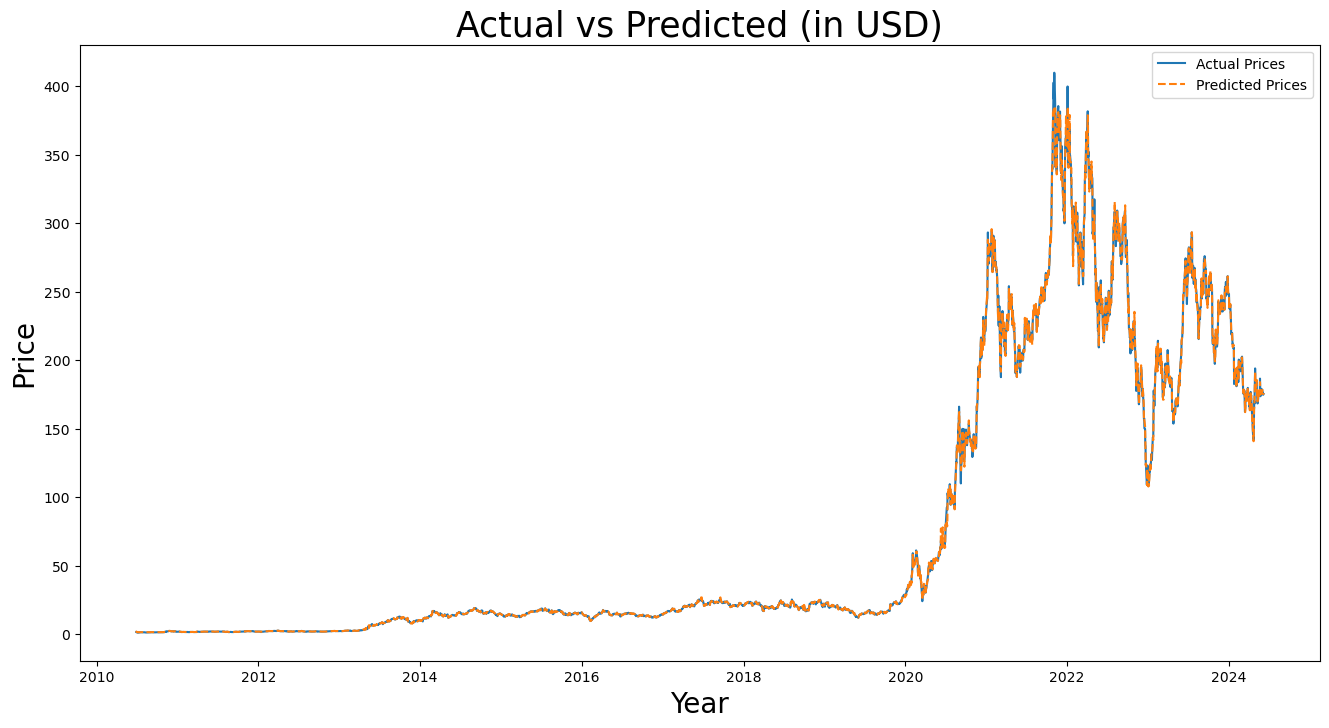

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], scaler.inverse_transform(y_train.values.reshape(-1, 1)), label='Actual Prices')
plt.plot(df['Date'],scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Prices', linestyle='dashed')
plt.xlabel('Year', size=20)
plt.ylabel('Price', size=20)
plt.title('Actual vs Predicted (in USD)', size=25)
plt.legend()
plt.show()